# TP Noté 1 : Dans la peau d'un influenceur data-scientist

```Ecole Centrale Nantes
Option InfoIA
PAPY: Programmation avancée python
TP3.2
Année 2023-2024
Auteur: Lucas Lestandi
lucas.lestandi@ec-nantes.fr
V2.0
```

**Durée 4h**

<div class="alert alert-danger" role="alert">
   <b> Attention : </b>  il s'agit d'un TP noté. Le notebook de rapport, ainsi que les fichiers/modules `.py` seront à déposer sur Hippocampus avant la séance suivante. Autrement dit, mercredi 23:59. <br>
    Bien entendu, vous pouvez travailler en groupe, mais pas plus de 3. Merci de m'informer pendant la séance des groupes, via slack par exemple.
</div>

*Dans ce TP, vous mettrez en oeuvre les connaissances acquises au cours de précédentes séances. Vous utiliserez à bon escient les paradigmes de programmation d'un vrai projet : des fonctions, des classes, et une structure de code utilisant des modules externes.*

Récemment, l'actualité a été marquée par de [nombreux articles](https://www.challenges.fr/economie/i-fly-bernard-lavion-de-bernard-ces-comptes-twitter-qui-font-enfler-la-polemique-sur-les-jets-prives_825097) relatant le mécontentement certains milliardaires face aux comptes twitter (et autre) relatant leurs déplacements en jet privé. On notera le cas [I fly Bernard](https://twitter.com/i_fly_Bernard), [l'avion de Bernard](https://www.instagram.com/laviondebernard/) coté français et [ElonJet](https://twitter.com/ElonJet) outre atlantique avec par Jack Sweeney. Les codes respectifs sont plus ou moins disponibles en ligne et plus ou moins faciles à suivre.  Dans tous les cas, ils s'appuient sur des données publiques puisque tous les avions doivent être équipés d'un émetteur ADSB donnant leur position. Ces données sont extraites des bases et traitées avec le langage le plus simple pour ces taches : python, évidemment. 

Le but de ce TP est de reproduire, dans un notebook, la capture des données ADSB, puis leur traitement pour afficher un trajet (avec matplotlib) et effectuer quelques traitements, par exemple pour une flotte complète. On proposera notre propre structure (de classe) simplifiée, mais modulaire. On commencera par une rapide analyse du code source de deux comptes automatisés cité au-dessus afin de déterminer comment en tirer profit pour accélérer notre développement.

## Analyse de code [1h max]
Les codes ["L'avion de Bernard"](https://github.com/laviondebernard/instagram) et ["ElonJet"](https://github.com/Jxck-S/plane-notify) sont très différent. 
Pour les deux codes, on proposera une analyse rapide en répondant aux questions suivantes.
1. **Récupération des sources** avec git
1. **Description de la structure du projet**, 
    - nombre de fichiers python, autres langages, documents
    - documentation et la facilité d'installation
    - Licence : A-t-on le droit d'utiliser ce code pour usage personnel? commercial?
1. Peut-on **exécuter** le script principal et/ou un exemple?
1. **Que fait le code ?** 
    - décrire la trame en quelques points clés
    - quelles sont les dépendances principales
    - Si la structure est complexe, on pourra utiliser la commande suivante pour dessiner un diagramme de classe et le commenter.
    ```shell
    $ pyreverse -o svg NOM-PAQUET .
    ```
    > `pyverse` fait parti du paquet pylint.
    - commenter la qualité de l'implémentation : respect des PEP, facilité de lecture, commentaires
    
1. **Évaluation de l'utilité**:
    - ce code est-il prêt à l'usage?
    - ce code peut-il être facilement utilisé?
    - ce code est-il modulaire? 
    - dans le contexte de ce "projet" peut-on utiliser ce code comme squelette? 

**Question conclusion:** On comparera ces deux paquets dans un court paragraphe avant de conclure sur leur utilisation dans la partie suivante.

## Une visu maison.
<div class="alert alert-warning" role="alert">
Comme vous le voyez, tout n'est pas bon à prendre dans un code trouvé en ligne. Cela peut être dû à plusieurs facteurs: inadéquation avec le projet en cours, trop grande complexité, mauvaise organisation, difficulté d'installation, etc. 
</div>

Nous allons réduire la complexité au minimum afin d'obtenir des résultats exploitables en quelques heures.

Pour cela, on utilisera tout de même certains paquets généralistes que l'on maitrise déjà (en théorie) et quelques autres spécifiques au problème, en particulier sous forme d'API.

**Pré-requis:**
- bibliothèques à installer : pandas, numpy, matplolib, cartopy/cartes

```mamba install -c conda-forge cartopy```

**Objectifs:**
- Installer openskyAPI et récupérer les données ADSB publiques grâce à l'API d'*openskynetworks*
- Créer une structure de classe permettant de représenter : des avions et des trajets. En option, on pourrait aimer représenter les aéroports.
- Proposer une visualisation avec matplotlib-cartopy d'un trajet
- Extraire un certain nombre d'informations issues des données de vol

**Les données**: Le système ADS-B est public, mais la conservation des données nécessite des moyens, ne serait-ce que pour le stockage et l'accès web. Pour cette raison les services proposent plusieurs versions selon le degré d'implication des utilisateurs (authentifiés ou non, payant ou non). 
- [openskynetworks](https://opensky-network.org/) est une association à but non lucratif qui récolte les signaux ADS-B (entre autres) et les rend accessibles gratuitement et sur enregistrement. Il semblerait que l'API python ne permette d'accéder qu'aux données en temps réel. D'autres modes d'accès sont possibles (requêtes web, etc.), en particulier à l'aide d'un compte. Pour ce TP, nous ferons sans. Les données retenues: 
    - l'api `opensky_api` pour récupérer des données en direct et tracer une carte "radar" autour de sa position
    - des données historiques téléchargées à l'avance sur ce même site au format pickle. 

## Exploration des données

> Installation openskyAPI
> - cloner les sources
> - Suivre le readme.md et installer avec pip
> - Explorer un peu les données : 
>   1. Combien d'avions volent en ce moment dans le monde?
>   1. Combien sont aux sol mais avec le transpondeur allumé?
>   1. Quelle est la vitesse moyenne des appareils dans le "carré" (42,51,-5,8)?
>   1. Proposer une ou deux autres métriques intéressantes. 
>   1. Recharger les données, les résultats sont-ils les mêmes? 

In [2]:
from opensky_api import OpenSkyApi
import time

In [ ]:
api = OpenSkyApi()
states = api.get_states(bbox=(42,51,-5,8)) # on récupére tous les vols en ce moment sur un zone couvrant l'essentiel de la France.

<div class="alert alert-danger" role="alert">
   <b> Attention : </b> pour des raisons de cout/bande passante, opensky api limite le nombre de requêtes gratuites par jour pour un utilisateur en suivant son ip. Il est donc vivement recommandé de ne pas relancer la méthode <code>get_states()</code>. Si la requete échoue dès le premier appel, vous pouvez utiliser les données <code> states.pkl </code>
</div>

```python
import pickle
with open('data/states.pkl', 'rb') as handle:
    states = pickle.load(handle)
```

On pourra récupérer les états correspondants aux avions avec `states.states` qui est une liste de vecteurs d'états. On retrouve la description dans la documentation.
> Represents the state of a vehicle at a particular time. It has the following fields:
> -  **icao24** - ICAO24 address of the transmitter in hex string representation.
> -  **callsign** - callsign of the vehicle. Can be None if no callsign has been received.
> -  **origin_country** - inferred through the ICAO24 address
> -  **time_position** - seconds since epoch of last position report. Can be None if there was no position report received by OpenSky within 15s before.
> -  **last_contact** - seconds since epoch of last received message from this transponder
> -  **longitude** - in ellipsoidal coordinates (WGS-84) and degrees. Can be None
> -  **latitude** - in ellipsoidal coordinates (WGS-84) and degrees. Can be None
> -  **geo_altitude** - geometric altitude in meters. Can be None
> -  **on_ground** - true if aircraft is on ground (sends ADS-B surface position reports).
> -  **velocity** - over ground in m/s. Can be None if information not present
> -  **true_track** - in decimal degrees (0 is north). Can be None if information not present.
> -  **vertical_rate** - in m/s, incline is positive, decline negative. Can be None if information not present.
> -  **sensors** - serial numbers of sensors which received messages from the vehicle within the validity period of this state vector. Can be None if no filtering for sensor has been requested.
> -  **baro_altitude** - barometric altitude in meters. Can be None
> -  **squawk** - transponder code aka Squawk. Can be None
> -  **spi** - special purpose indicator
> -  **position_source** - origin of this state's position: 0 = ADS-B, 1 = ASTERIX, 2 = MLAT, 3 = FLARM

On va se satisfaire d'extraire les positions, vitesses et orientation pour les positionner sur la carte ainsi que icao24 et calssign pour pouvoir identifier les appareils et les croiser avec d'autres bases de données.

> Créer une classe représentant les avions avec les caractéristiques **réduites** listées au-dessus. Rappel, il est possible de créer plusieurs méthodes d'instanciation avec le décorateur `@classmethod`. **Ne pas oublier la documentation de votre code, il sera relu!** 
>
> On instanciera cette classe pour tous les `states` obtenu avec opensky_api afin de les sauvegarder (format de votre choix) et surtout de les afficher sur une carte.

On écrira une fonction d'affichage qui place les avions sur la carte et représente leur vitesse (taille) et leur direction de manière similaire à ce qui est proposé dans l'exemple.
```python
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.colors import Normalize
from matplotlib.textpath import TextPath
from matplotlib.transforms import Affine2D
from avion import Avion
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

def plot(liste_avion, *args, **kwargs):
    fig = plt.figure(figsize=(15,15))

    # Create a GeoAxes in the tile's projection.
    ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)
    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([-5, 8, 42, 51], crs=ccrs.Geodetic())
    # Add the Stamen data at zoom level 8.
    ax.add_image(cimgt.GoogleTiles("RGB"), 8)

    SYMBOL = TextPath((0, 0), "✈") # Définie le marquer avion
    #boucle de plot a écrire

    fig.savefig("carte.jpg")
    plt.show()
```

On obtiendra un résultat similaire à celui ci! Ne pas hésiter à utiliser d'autres fonds de cartes, icones ou types de représentation (vecteurs...)
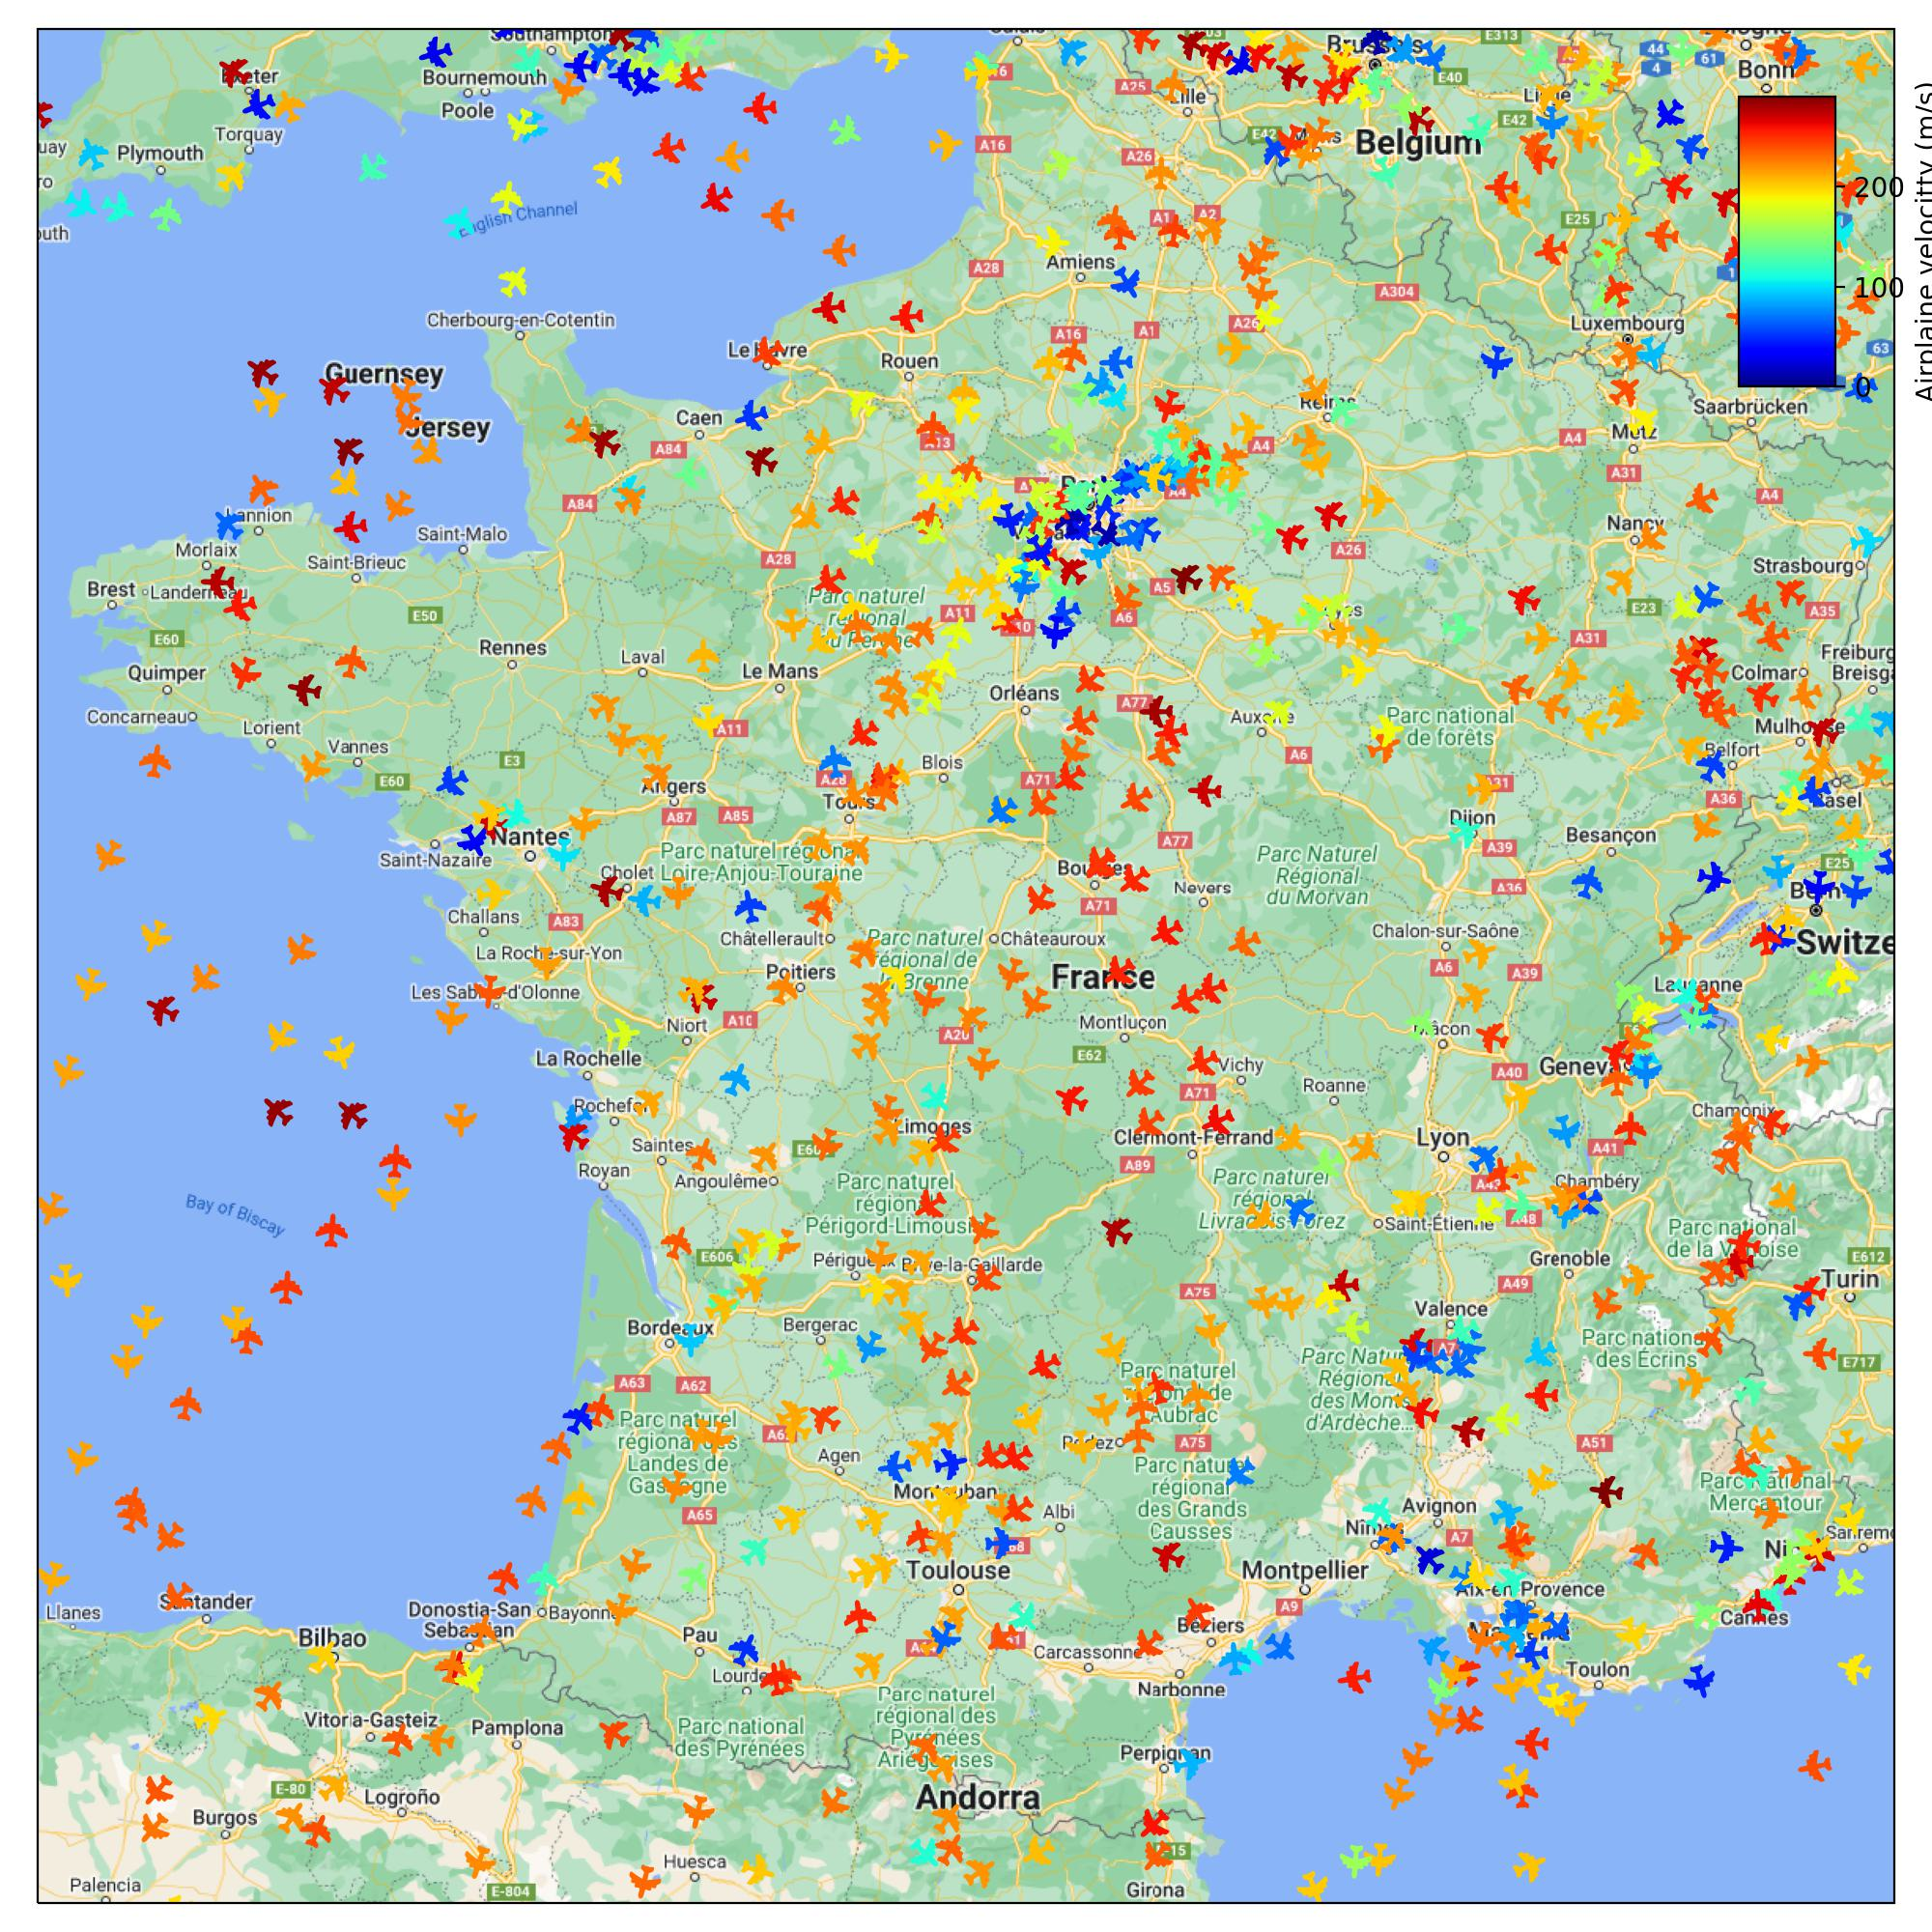


In [9]:
%load_ext autoreload
%autoreload 2

### Données historiques

Dans cette seconde partie, nous allons complétement nous affranchir de l'API temps réel et travailler sur des données historiques très similaires. 

Vous trouverez les données à l'adresse suivante : https://box.ec-nantes.fr/index.php/s/SKCyn4ZaQSfGeRb protégées par le mot de passe `PAPY23`. Attention, certains fichiers sont très volumineux (et difficiles à charger en mémoire), lisez attentivement la description ci-dessous et téléchargez celui qui vous convient. 

Nous allons croiser deux bases de données:
- Dataframe 1 : `data/flights20220613/cleaned.dat` que vous trouverez sur la box du TP. Il contient tous les vols capturés par le système de balises d'OpenSky pour la journée du 13 juin 2022 (dernières données disponibles au moment de la préparation de ce TP). Ces dernières sont au format binaire de pickle. Il suffira d'utiliser la commande `pd.read_pickle("path_to_data/flights20220613/cleaned.dat")` pour charger le dataframe pandas. Ces données ont été nétoyés au préalable pour ne pas s'encombrer de variables inutiles dans le cadre de ce TP. Vous constaterez que ces données sont de taille importante (environs 5Go) ce qui rend leur manipulation contraignante sur un PC portable. Dans ces conditions, 3 sous ensembles ont été extrait pour permettre de s'habituer aux données de répondre aux questions.
    1. `data/flights20220613/AF_daily.dat` contient tous les vols d'appareils Air France compris dans la base de donnée (plus petit que la flotte réelle)
    2. `data/flights20220613/AA_daily.dat` contient tous les vols d'appareils American Airlines, de très loin le plus gros ensemble commercialµ
    3. `data/flights20220613/AAForce_daily.dat` contient tous les vols d'appareils de l'armée de l'air américaine pour lesquels le transpondeur était allumé. Les appareils et la nature des vols sont plus variés mais il comprend beaucoup de données inexploitables.

- Une seconde base de données `data/flights20220613/aircraftDatabase-2022-06.csv`, beaucoup plus legère contient tous les aéronefs répertoriés dans la base de donnée Opensky API. Elle a été utilisée, pour créer les sous-ensembles précédents. Elle vous sera par exemple utile pour déterminer le type d'aéronef.

>  Dans un premier temps, répondez aux questions sur l'un des trois dataframes réduit. Ensuite, si vous souhaitez aller plus loin, n'hésitez pas à charger les données complètes et les croiser avec la base de donnée des aéronefs. 


### Découverte des données

1. Charger les données allégées de votre choix du dump hebdomadaire d'opensky-network.
- Que contient le fichier?
- Quelle plage temporelle? 
- Donner quelques données moyennes : vitesse, position, nombre d'avions par tranche horaire.
- On en profitera pour mesurer le temps (non négligeable) pour effectuer ces calculs.
2. Charger les données relatives aux aéronefs
- les présenter rapidement
- quelles sont les données utiles pour se lier à l'autre base de données? 
- quels sont les 5 types d'appareils les plus représentés? 
- quelle est la compagnie la plus représentée (en nombre d'appareils)?

3. Joindre les deux tableaux en ne conservant, pour la base de données des aéronefs que la compagnie, le type d'appareil, le constructeur et l'ICAO24 et l'immatriculation. 


### Réduire les données pour pouvoir les exploiter et tracer une figure
Une fois que l'on a bien les données en main on s'intéresse au déplacement d'un seul appareil (comme pour nos deux influenceurs).

- Comment ces données s'intègrent-elles dans la classe avion que l'on a créé précédemment? 
- Proposer un refactoring qui permette d'éviter les doublons lorsque l'on souhaite tracer les trajectoires d'un appareil au cours d'une journée
- Implémenter ces changements.
- Tracer un vol de votre choix (paramètres à déterminer) trajectoire journalière avec une approche similaire à l'exercice précédent. Vous pourrez au choix utiliser le fond de carte de google ou une carte plus légère montrant simplement les cotes et divisions administratives: 
```python
        import cartopy.crs as ccrs
        import cartopy.io.img_tiles as cimgt
        import cartopy.feature as cf
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(10,10),dpi=100)

        # Create a GeoAxes in the tile's projection.
        ax = fig.add_subplot(1, 1, 1, projection=tile.crs)
        # Limit the extent of the map to a small longitude/latitude range.
        window=[plane.lon.min()-5,plane.lon.max()+.5,plane.lat.min()-1,plane.lat.max()+1]
        ax.set_extent(window, crs=ccrs.Geodetic())
        
        # Option Google, vous pouvez jouer sur le niveau de zoom.
        #tile=cimgt.GoogleTiles("RGB")
        #ax.add_image(tile,6)
        #option light avec les caractéristiques sus nomées
        ax.add_feature(cf.BORDERS)
        ax.add_feature(cf.STATES)
        ax.add_feature(cf.COASTLINE)
        
        cmap = plt.cm.get_cmap('jet')
        # you need to define x,y and v to make sense
        ax.scatter(x,y,color=cmap(v), transform=ccrs.Geodetic())
        plt.show()
```
A cette figure, vous ajouterez un En-tete avec La compagnie, le modèle et constructeur, l'immatriculation. Vous enrichirez encore votre figure avec une image montrant à quoi ressemble l'avion en question. Bien sûr, cette dernière étape doit être traitée automatiquement avec une requête web. 
- Tracer tous les vols de la journée! 
**Bonus**: vous êtes libres de créer votre propre sous-ensemble à partir des données complètes de la journée. Par exemple dans une région, ou pour une autre compagnie, un ensemble de jet privés, etc. 

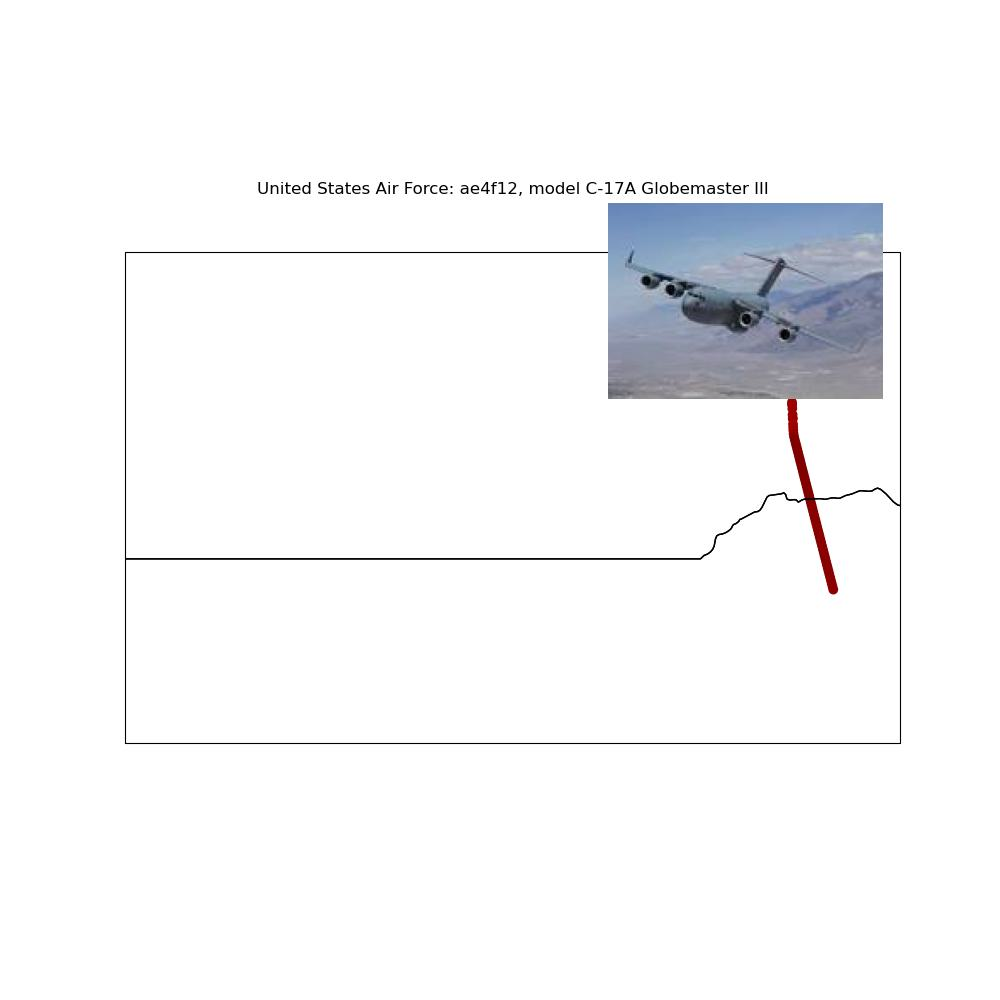
